In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

from tqdm.auto import tqdm


In [ ]:
training_data = datasets.CIFAR10(root= "data", train= True, download= True, transform= ToTensor())
test_data = datasets.CIFAR10(root= "data", train= False, download= True, transform =ToTensor())

100%|██████████| 170498071/170498071 [00:05<00:00, 30767537.72it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
train_data, val_data = torch.utils.data.random_split(training_data, [40000, 10000], torch.Generator().manual_seed(9))

In [ ]:
train_dataloader = DataLoader(train_data, batch_size= 64)
val_dataloader = DataLoader(val_data, batch_size= 64)
test_dataloader = DataLoader(test_data, batch_size= 64)

tensor([1, 4, 6, 0, 1])


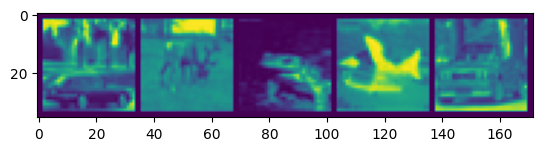

In [ ]:
images, labels = next(iter(train_dataloader))
images, labels = images[:5], labels[:5]

plt.imshow(torchvision.utils.make_grid(images)[0,:,:])
print(labels)

In [ ]:
class C10CNN(nn.Module):

  def __init__(self):
    super(C10CNN, self).__init__()

    self.conv = nn.Sequential(
        nn.Conv2d(3, 32, 5), # in, out, ker, str
        nn.BatchNorm2d(32),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2),
        nn.Conv2d(32, 64, 5),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2),
        nn.Conv2d(64, 128, 3),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2),
        nn.Dropout(0.25),
      )

    self.fc = nn.Sequential(
        nn.Flatten(),
        nn.Linear(128, 1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(1024,10),
      )

  def forward(self, x):
    x = self.conv(x)
    x = self.fc(x)

    return x

In [ ]:

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
model = C10CNN().to(device)



In [ ]:
lr = 1e-4
loss_fn = nn.CrossEntropyLoss()
optmizer= torch.optim.Adam(model.parameters(), lr= lr)

num_epochs = 20

In [ ]:

from sklearn.metrics import accuracy_score

def train_model(model, dataloader, optmizer, loss_fn):
    model.train()
    train_loss, train_acc= 0, 0

    for X, y in dataloader:
        # Forward Pass
        X, y = X.to(torch.device("cuda")), y.to(torch.device("cuda"))
        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        train_loss += loss
        train_acc += accuracy_score(y.cpu(), y_pred.cpu().argmax(dim= 1))

        # Back Propagation
        optmizer.zero_grad()
        loss.backward()
        optmizer.step()

        train_loss /= len(dataloader)

    train_acc /= len(dataloader)
    print(f"Train loss: {train_loss:.4f} | Train accuracy: {train_acc:.4f}")

    return train_loss, train_acc

In [ ]:

def val_model(model, dataloader, optmizer, loss_fn):
  model.eval()
  val_loss, val_acc= 0, 0

  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      y_pred = model(X)

      val_loss += loss_fn(y_pred, y)
      val_acc += accuracy_score(y.cpu(), y_pred.cpu().argmax(dim= 1))

      val_loss /= len(dataloader)

  val_acc /= len(dataloader)
  print(f"Val loss: {val_loss:.4f} | Val accuracy: {val_acc:.4f}")

  return val_loss, val_acc

In [ ]:
torch.manual_seed(0)

train_loss_wobn = []
train_acc_wobn = []
val_loss_wobn = []
val_acc_wobn = []
train_loss_wbn = []
train_acc_wbn = []
val_loss_wbn = []
val_acc_wbn = []

for epoch in tqdm(range(num_epochs)):

    print("--------------------------------------------------------")

    print(f"Epoch {epoch + 1}/{num_epochs}")

    print("Model  ")
    x1 = train_model(model, train_dataloader, optmizer, loss_fn)
    train_loss_wobn.append(x1[0])
    train_acc_wobn.append(x1[1])
    x2 = val_model(model, val_dataloader, optmizer, loss_fn)
    val_loss_wobn.append(x2[0])
    val_acc_wobn.append(x2[1])



  0%|          | 0/20 [00:00<?, ?it/s]

--------------------------------------------------------
Epoch 1/20
Model 1 
Train loss: 0.0025 | Train accuracy: 0.3449
Val loss: 0.0079 | Val accuracy: 0.4718
--------------------------------------------------------
Epoch 2/20
Model 1 
Train loss: 0.0021 | Train accuracy: 0.4708
Val loss: 0.0069 | Val accuracy: 0.5293
--------------------------------------------------------
Epoch 3/20
Model 1 
Train loss: 0.0021 | Train accuracy: 0.5296
Val loss: 0.0068 | Val accuracy: 0.5528
--------------------------------------------------------
Epoch 4/20
Model 1 
Train loss: 0.0020 | Train accuracy: 0.5679
Val loss: 0.0066 | Val accuracy: 0.5878
--------------------------------------------------------
Epoch 5/20
Model 1 
Train loss: 0.0021 | Train accuracy: 0.5932
Val loss: 0.0066 | Val accuracy: 0.5952
--------------------------------------------------------
Epoch 6/20
Model 1 
Train loss: 0.0019 | Train accuracy: 0.6147
Val loss: 0.0062 | Val accuracy: 0.6207
----------------------------------

In [ ]:

train_loss_wobn_np = [item.detach().cpu().numpy() for item in train_loss_wobn]
train_acc_wobn_np = [item for item in train_acc_wobn]
val_loss_wobn_np = [item.detach().cpu().numpy() for item in val_loss_wobn]
val_acc_wobn_np = [item for item in val_acc_wobn]

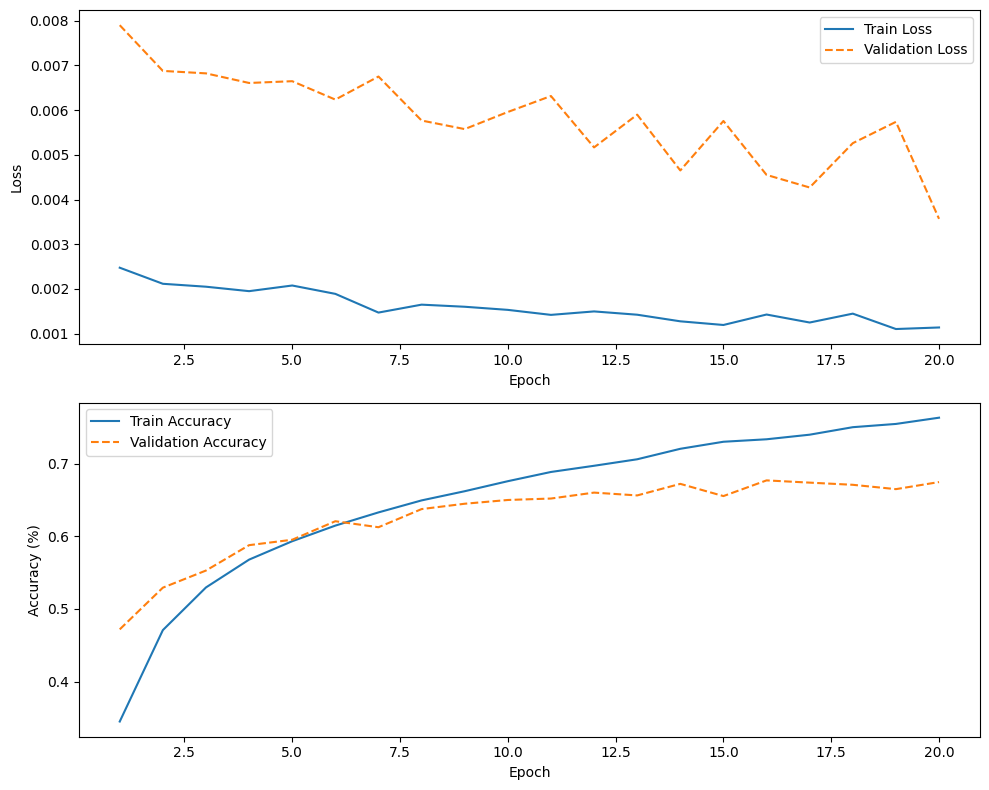

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

ax1.plot(range(1, num_epochs+1), train_loss_wobn_np, label='Train Loss')
ax1.plot(range(1, num_epochs+1), val_loss_wobn_np, label='Validation Loss', linestyle='dashed')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(range(1, num_epochs+1), train_acc_wobn_np, label='Train Accuracy')
ax2.plot(range(1, num_epochs+1), val_acc_wobn_np, label='Validation Accuracy', linestyle='dashed')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()


plt.tight_layout()
plt.show()
